In [ ]:
# default_exp environment

In [2]:
#export
import torch
import numpy as np
from math import pi, cos, sin
from tqdm.auto import tqdm
from scipy.spatial import distance

# Helpers 

In [3]:
#export
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson


def get_distance(x):
    ''' USE scipy.spatial.distance instead !!!!'''
    M = np.reshape(np.repeat(x[ :, :], x.shape[0], axis = 0), (x.shape[0], x.shape[0], 2))
    Mtrans = M.transpose(1,0,2)
    distance = np.sqrt(np.square(M[:,:, 0]-Mtrans[:,:, 0])
                     + np.square(M[:,:, 1]-Mtrans[:,:, 1]))  
    return distance

def isBetween(a, b, c, epsilon = 0):
    crossproduct = (c[1] - a[1]) * (b[0] - a[0]) - (c[0] - a[0]) * (b[1] - a[1])

    # compare versus epsilon for floating point values, or != 0 if using integers
    if abs(crossproduct) > epsilon:
        return False

    dotproduct = (c[0] - a[0]) * (b[0] - a[0]) + (c[1] - a[1])*(b[1] - a[1])
    if dotproduct < 0:
        return False

    squaredlengthba = (b[0] - a[0])*(b[0] - a[0]) + (b[1] - a[1])*(b[1] - a[1])
    if dotproduct > squaredlengthba:
        return False

    return True

def isBetween_ab_Vec(a, b, c, epsilon = 0):
    mask = np.array([True]*a.shape[0])
    
    crossproduct = (c[1] - a[:,1]) * (b[:,0] - a[:,0]) - (c[0] - a[:, 0]) * (b[:, 1] - a[:, 1])
    mask[np.argwhere(abs(crossproduct) > epsilon)] = False    

    dotproduct = (c[0] - a[:, 0]) * (b[:, 0] - a[:, 0]) + (c[1] - a[:, 1])*(b[:, 1] - a[:, 1])
    mask[np.argwhere(dotproduct < 0)] = False

    squaredlengthba = (b[:, 0] - a[:, 0])*(b[:, 0] - a[:, 0]) + (b[:, 1] - a[:, 1])*(b[:, 1] - a[:, 1])
    mask[np.argwhere(dotproduct > squaredlengthba)] = False
    
    return mask

def isBetween_c_Vec(a, b, c, epsilon = 0):
    mask = np.array([True]*c.shape[0])
    
    crossproduct = (c[:,1] - a[1]) * (b[0] - a[0]) - (c[:,0] - a[0]) * (b[1] - a[1])
    mask[np.argwhere(abs(crossproduct) > epsilon)] = False    

    dotproduct = (c[:, 0] - a[0]) * (b[0] - a[0]) + (c[:, 1] - a[1])*(b[1] - a[1])
    mask[np.argwhere(dotproduct < 0)] = False

    squaredlengthba = (b[0] - a[0])*(b[0] - a[0]) + (b[1] - a[1])*(b[1] - a[1])
    mask[np.argwhere(dotproduct > squaredlengthba)] = False
    
    return mask

def is_c_between_ab(a, b, c, radius = 1):    
    distances = np.abs(np.cross(b-a, a-c))/np.linalg.norm(b-a,axis=1)
    return distances < radius 
    

# Environment 

In [54]:
#export
class target_env():
    def __init__(self,
                 Nt = 1000,
                 L = 200,
                 at = 1,
                 ls = 2,
                 agent_step = 1,
                 boundary_condition = 'periodic'):
        
        self.Nt = Nt
        self.L = L
        self.at = at
        self.ls = ls
        self.boundary_condition = boundary_condition
        
        self.init_env()
        
        self.agent_step = agent_step 
                
    def init_env(self):
        self.target_positions = torch.rand(self.Nt, 2)*self.L
        self.agent_pos = torch.rand(2)*self.L
        self.previous_pos = self.agent_pos.clone()
        
          
    def step(self, direction):        
            
        # Save previous position to check if crossing happened
        self.previous_pos = self.agent_pos.clone()
            
        self.agent_pos[0] = self.agent_pos[0] + self.agent_step*cos(direction)
        self.agent_pos[1] = self.agent_pos[1] + self.agent_step*sin(direction)
        
        self.check_bc()
                
    def check_encounter(self):
        encounters = isBetween_c_Vec(self.agent_pos, self.previous_pos, self.target_positions, epsilon = self.at)
        
        if sum(encounters) > 0:   
            distance_previous_pos = torch.sqrt((self.agent_pos[0]-self.target_positions[:, 0])**2 + (self.agent_pos[1]-self.target_positions[:, 1])**2)            
            
            # checking which encountered point is closer to previous position
            min_distance_masked = torch.argmin(distance_previous_pos[encounters])
            first_encounter = torch.arange(self.Nt)[encounters][min_distance_masked]
            
            # If there was encounter, update the position to (pos target + ls)
            self.agent_pos[0] = self.target_positions[first_encounter, 0] + self.ls*np.cos(torch.rand(1)*2*pi)
            self.agent_pos[1] = self.target_positions[first_encounter, 1] + self.ls*np.sin(torch.rand(1)*2*pi)
                        
            self.check_bc()
            
            return 1
        
        else: return 0
        
    def check_bc(self): 
        if self.boundary_condition == 'reflectant':
            while torch.max(self.agent_pos) > self.L or torch.min(self.agent_pos)< 0: 
                out_high = self.agent_pos > self.L
                out_low = self.agent_pos < 0
                self.agent_pos[out_high] = self.agent_pos[out_high] - 2*(self.agent_pos[out_high] - self.L)
                self.agent_pos[out_low] = - self.agent_pos[out_low]


        elif self.boundary_condition == 'periodic':
            while torch.max(self.agent_pos) > self.L or torch.min(self.agent_pos)< 0: 
                out_high = self.agent_pos > self.L
                out_low = self.agent_pos < 0 
                self.agent_pos[out_high] = self.agent_pos[out_high] - self.L
                self.agent_pos[out_low] = self.L + self.agent_pos[out_low]  


In [60]:
#export
''' STUFF WRONG HERE'''
def target_search(Nt = 100, at = 1, ls = 1,
                  rho = 1e-3,
                  L= 1000,   
                  N = 1000, T = 1000,
                  sample_step = None,
                  **args_step):

    diag = np.sqrt(2*L**2)

    target_positions = np.random.rand(Nt, 2)*L

    pos = np.zeros((N, T, 2))
    pos[:, 0, :] = np.random.rand(N, 2)*L

    encounter = np.zeros((N, T)).astype(bool)
    
    real_steps = []
    sampled_steps = np.zeros((N,T))

    
    for t in tqdm(range(1,T)):
        
        angles = np.random.uniform(low = 0, high = 2*np.pi, size = N)
        
        if sample_step is None:
            steps = np.random.randn(N)
        else:
            steps = sample_step(**args_step)
            
        sampled_steps[:, t] = steps        
        
        pos[:, t, 0] = (pos[:, t-1, 0] + steps*np.cos(angles))%L
        pos[:, t, 1] = (pos[:, t-1, 1] + steps*np.sin(angles))%L            
        

        masked = np.array([False]*N)
        for idxT, pT in enumerate(target_positions):
            
            mask = is_c_between_ab(pos[:, t, :], pos[:, t-1, :], pT, radius = at)

            masked += np.array(mask)
            
            # Check real distance travelled
            if np.sum(mask) > 0:
                real_steps += np.abs(pos[mask == True, t, :].copy() - pT).tolist()[0]
            
        
            pos[mask == True, t, :] = pT
        
        encounter[:, t] = masked
        sum_m = np.sum(masked)

        if sum_m > 0:
            angle = np.random.uniform(low = 0, high = 2*np.pi, size = sum_m)
            pos[masked == True, t, 0] += ls*np.cos(angle)
            pos[masked == True, t, 1] += ls*np.sin(angle)

        
                
    return encounter, real_steps, sampled_steps
                

In [78]:
#export
def target_search_onhit(Nt = 100, at = 1, ls = 1,
                        rho = 1e-3,
                        L= 1000,   
                        N = 1000, T = 1000,
                        sample_step = None,
                        **args_step):
    
    

    target_positions = np.random.rand(Nt, 2)*L

    pos = np.zeros((N, T, 2))
    pos[:, 0, :] = np.random.rand(N, 2)*L

    encounter = np.zeros((N, T-1))

    for t in tqdm(range(1,T)):

        angles = np.random.uniform(low = 0, high = 2*np.pi, size = N)

        if sample_step is None:
            steps = np.random.randn(N)
        else:
            steps = sample_step(**args_step)
            

        pos[:, t, 0] = (pos[:, t-1, 0] + steps*np.cos(angles))%L
        pos[:, t, 1] = (pos[:, t-1, 1] + steps*np.sin(angles))%L    

        mask = np.zeros(N).astype(bool)
        for idxT, pT in enumerate(target_positions):            
            mask += is_c_between_ab(pos[:, t, :], pos[:, t-1, :], pT, radius = at)

        
        encounter[:, t-1] = mask.astype(int)

        # Distance to initial position (t-1)
        dist = distance.cdist(pos[:,t-1, :], target_positions, metric='euclidean').transpose()

        dist_crossed = dist*mask
        particles_hitting = np.sum(dist_crossed, axis = 0)
        particles_hitting = np.argwhere(particles_hitting != 0)
        
        
  
        for idx_n in particles_hitting:
            
            closest_target = np.argmin(dist[:, idx_n])
            angle = np.random.uniform(low = 0, high = 2*np.pi)
            pos[idx_n, t, 0] = (target_positions[closest_target, 0] + ls*np.cos(angle))%L
            pos[idx_n, t, 1] = (target_positions[closest_target, 1] + ls*np.sin(angle))%L
                    
    return encounter#, pos, target_positions

In [74]:
from rl_optimal_search.diffusion_walks import lw_step
Nt = 150
density = 0.01
N = 8; T = int(300)
L = 1e4#Nt/density
at = 0.5
ls = 3

In [75]:
encs, pos, targ_pos = target_search_onhit(Nt = Nt, N = N, T = T, alpha = 0.2, L = L, at = at, ls = ls, sample_step = lw_step, num_part = N)


  0%|          | 0/299 [00:00<?, ?it/s]

In [44]:
disps = pos[:,1:,:]-pos[:,:-1,:]

In [51]:
h, e = np.histogram(np.abs(disps.flatten()), bins = np.linspace(0.1, 2, 100))

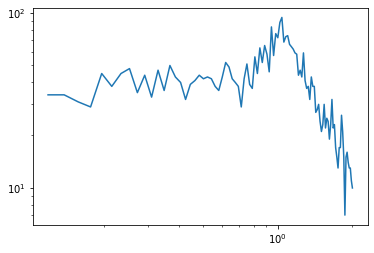

In [52]:
plt.loglog(e[1:], h)

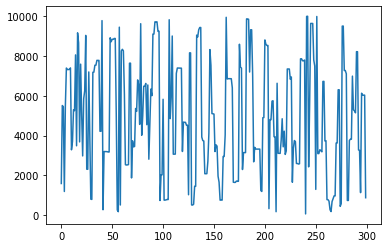

In [19]:
import matplotlib.pyplot as plt
idx = 2
plt.plot(pos[idx,:,0])

In [25]:
encs.shape

(8, 299)

(47.94867911144583, 9997.064815968548)

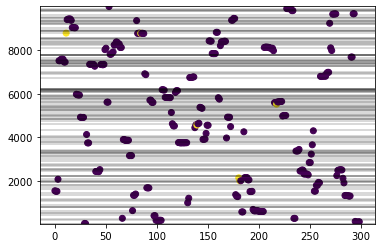

In [77]:
import matplotlib.pyplot as plt
idx = 7
for tp in targ_pos:
    plt.axhline(tp[0], c = 'k', alpha = 0.2)
plt.scatter(np.arange(T-1), pos[idx,:-1,0], c = encs[idx])
plt.ylim(pos[idx,:-1,0].min()-10, pos[idx,:-1,0].max()+10)

(4737.746181532916, 5011.75637863089)

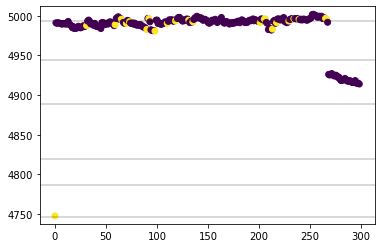

In [43]:
import matplotlib.pyplot as plt
idx = 6
for tp in targ_pos:
    plt.axhline(tp[0], c = 'k', alpha = 0.2)
plt.scatter(np.arange(T-1), pos[idx,:-1,0], c = encs[idx])
plt.ylim(pos[idx,:-1,0].min()-10, pos[idx,:-1,0].max()+10)

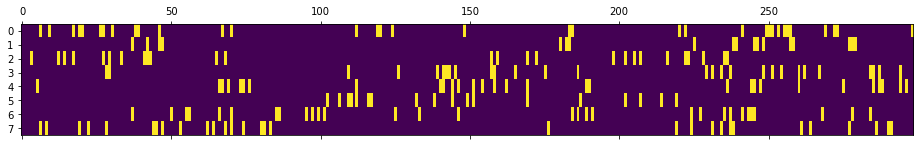

In [255]:
plt.matshow(a, aspect = 'auto')

In [250]:
from nbdev.export import notebook2script
notebook2script()

Converted cluster_launch.ipynb.
Converted diffusion_walks.ipynb.
Converted environment.ipynb.
Converted theoretical_policy.ipynb.
